In [1]:
import os
import json
import shutil
import lzma

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import scipy.sparse as sps
from scipy.sparse import csr_matrix

import networkx as nx
import louvain
import igraph as ig

C:\Users\rdm42\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
<ipython-input-1-4bdac6f14819>:17: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  import louvain


In [2]:
def plot_degree_summary(Mwd=None, G=None):
    
    if G is None:
        dw = Mwd.sum(axis=1)
        print(f"Number of words: {Mwd.shape[0]}")
        print(f"Number of documents: {Mwd.shape[1]}")
    else:
        dw = pd.Series(dict(G.degree()))
        print(f"Number of words: {len(G)}")
        

    # Summary analysis of the network:
    gamma = 1 + dw.size/np.log(dw / dw.min()).sum()
    print(f"Network's gamma is {gamma:.2f}")


    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    plt.suptitle("Word degree summary", size=20)

    # Words' degrees

    n = 6
    s = dw.sort_values(ascending=False)
    custom_ticks = [(s.size//n)*l for l in range(n+1)]
    custom_labels = s.index[custom_ticks]

    axs[0].set_title("Degrees", size=16)
    axs[0].set_ylabel("Word count across documents", size=12)
    axs[0].semilogy(s)
    axs[0].set_xticks(custom_ticks)
    axs[0].set_xticklabels(custom_labels, rotation=30)


    # Words degree distribution

    k = np.unique(dw)
    pk = np.histogram(dw,np.append(k,k[-1]+1))[0]
    pk = pk/pk.sum()
    # Pk = 1-np.cumsum(pk)
    p_ideal = ((gamma-1)/k.min()) * ((k/k.min())**(-gamma))

    label = r'$\gamma$' + f" = {gamma:.2f}\n" + r'$k_{min}$' + f" = {k.min()}"
    axs[1].loglog(k, pk, 'o')
    axs[1].loglog(k, p_ideal,label=label)
    axs[1].set_title("Distribution", size=16)
    axs[1].set_xlabel("k", size=12)
    axs[1].set_ylabel("$p_k$", size=12)
    axs[1].legend(loc='upper right')

    plt.tight_layout()
    
    return gamma, fig, axs

In [3]:
def clean_Mwd_matrix(Mwd,words,documents):

    # remove elements that are too central, e.g., #covid19
    not_wanted = Mwd.sum(axis=1) > Mwd.shape[1]/4
    text = "removing: " + ", ".join(words[not_wanted])
    words = words[~not_wanted]
    Mwd = Mwd[~not_wanted,:]

    # remove documents and words with fewer than 2 links
    while True:
        dim_old = Mwd.size
        
        # remove documents with less than 2 words
        wanted = Mwd.sum(axis=0) >= 2
        Mwd = Mwd[:,wanted]
        documents = documents[wanted]

        # remove words in less than 2 documents
        not_wanted = Mwd.sum(axis=1) < 2
        text = text + ", " + ", ".join(words[not_wanted])
        words = words[~not_wanted]
        Mwd = Mwd[~not_wanted,:]
        
        # exit criterion
        if (dim_old == Mwd.size): break

    print(text)
    return Mwd, words, documents

def logg(x):
    y = np.log(x)
    y[x==0] = 0
    return y



def probability_matrices(Mwd, equalik = True, tform = False):

    if equalik: # documents equally likely
        Pwd = Mwd/Mwd.sum(axis=0) #/ Mwd.shape[1]    ## Por qué aquí se divide entre el número de columnas???
        
    else: # documents proportional to their length
        Pwd = Mwd / Mwd.sum()                       ## Aquí la suma por columnas no da 1!!! entonces no es matriz estocástica
    # TF-IDF format
    
    if (tform):
        iw = -logg(np.sum(Mwd>0,axis=1).flatten()/Mwd.shape[1])
        Pwd = sps.diags(np.array(iw)[0])*Pwd # TF-IDF form
        Pwd = Pwd/Pwd.sum() # normalize, treat it as Pwd
        
    
    
    # Creo que aquí debe ser .dot ..............
    
    # words and document matrices
    pd = Pwd.sum(axis=0)
    Pww = (Pwd/pd).dot(Pwd.T)
    
    pw = Pwd.sum(axis=1)
    Pdd = (Pwd.T/pw).dot(Pwd)
    
    
    # joint words and document matrix - documents first
    Paa = sps.hstack((sps.csr_matrix((Pwd.shape[1],Pwd.shape[1])),Pwd.T))
    Paa = sps.vstack((Paa,sps.hstack((Pwd,sps.csr_matrix((Pwd.shape[0],Pwd.shape[0]))))))
    Paa = Paa/2.0
    
    return Pwd, Pww, Pdd, Paa

# Reading metadata

In [4]:
download_dir = os.path.join('..','0_data','downloaded_posts')
metadata_paths = [os.path.join(download_dir,f) for f in os.listdir(download_dir) if f.endswith('.json.xz')]

In [5]:
additional_data = []

for i,path in enumerate(metadata_paths):

    with lzma.open(path, 'rt') as file:
        data_dict = json.load(file)
    
    short = data_dict['node']['shortcode']
    user  = data_dict['node']['owner']['username']
    likes = data_dict['node']['edge_media_preview_like']['count']

    additional_data.append((short,user,likes))

additional_data = pd.DataFrame(additional_data, columns=['Short','user','likes'])

additional_data.head(3)

,Short,user,likes
0,fNO52Nxluy,amenstyle,61
1,lzQl_gRlnD,amenstyle,374
2,mrzAb-Rlkt,amenstyle,175


# Reading clean data

In [11]:
captions_path = os.path.join('..','0_data','text_clean.xlsx')
s = ' '

text_col = 'clean_caption'

with pd.ExcelFile(captions_path) as xl:
    data = xl.parse(index_col=0) \
             .merge(additional_data, on='Short', how='left', validate='m:1') \
             .drop_duplicates() \
             .reset_index(drop=True)

# Inclusion of username in captions
for col in ['clean_caption','clean_autocaption','clean_all']:
    data[col] = data['user'] + ' ' + data[col]

# collection of words
words = np.unique([token
                   for tokens in data.dropna(subset=[text_col])[text_col].str.split()
                   for token in tokens])

documents = data[text_col].values

# words dictionary
words_dict = {wrd:i for i,wrd in enumerate(words)}

# Occurrence matrix $M_{wd}$

In [12]:
# occurrence matrix for words
Mwd = csr_matrix((len(words_dict), data.shape[0]), dtype = np.int8).toarray()

for j,doc in data[text_col].dropna().items():
    for token in doc.split():
        Mwd[words_dict[token],j] += 1
        
        
# remove words that are used once or twice
select = Mwd.sum(axis=1) > 2
Mwd = Mwd[select,:]
words = words[select]

# remove documents that do not contain words
select = Mwd.sum(axis=0) > 0
Mwd = Mwd[:,select]
documents = documents[select]

# Further cleaning and probability matrices computation
Mwd, words, documents = clean_Mwd_matrix(Mwd,words,documents)
Pwd, Pww, Pdd, Paa = probability_matrices(Mwd, tform=False)

removing: , , 


Number of words: 302
Number of documents: 233
Network's gamma is 2.06


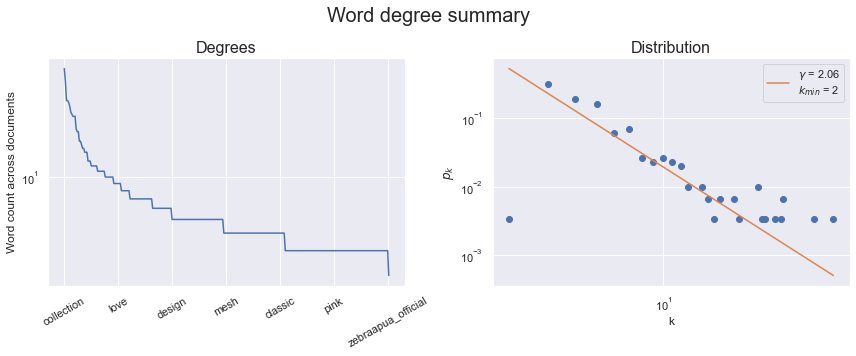

In [13]:
Mwd_df = pd.DataFrame(Mwd,index=words,columns=documents)
Pww_df = pd.DataFrame(Pww,index=words,columns=words)

gamma, fig, axs = plot_degree_summary(Mwd_df)

# Objectification rate per word

,Id,obj_rate
0,accessory,1.00
1,aesthetic,0.50
2,all,0.75


,obj_rate
count,302.000000
mean,0.560841
std,0.311861
min,0.000000
25%,0.333333
50%,0.636364
75%,0.800000
max,1.000000


<Axes: xlabel='obj_rate', ylabel='Density'>

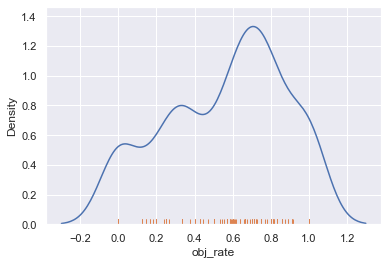

In [14]:
obj_docs = data.set_index(text_col) \
               .query("Objectify==1") \
               .index.drop_duplicates() \
               .intersection(Mwd_df.columns)


# Objectification rate for each word catalogue
# obj_rate = times the word is used in an objectifying post / times the word is used
obj_rate_cat = (Mwd_df[obj_docs].sum(axis=1) / Mwd_df.sum(axis=1)) \
               .to_frame().rename(columns={0:'obj_rate'}) \
               .reset_index(names='Id')

display(obj_rate_cat.head(3))
display(obj_rate_cat.describe())


sns.kdeplot(data=obj_rate_cat, x='obj_rate')
sns.rugplot(data=obj_rate_cat, x='obj_rate')

### La distribución luce multimodal

In [15]:
links = Pww_df.melt(ignore_index=False, var_name='Target', value_name='Weight') \
              .reset_index() \
              .rename(columns={'index':'Source'})

links['temp_key'] = links.apply(lambda row: ''.join(sorted([row['Source'],row['Target']])),axis=1)

links.groupby('temp_key')['Weight'].std().unique()

array([           nan, 0.00000000e+00, 1.73472348e-18, 8.67361738e-19,
       6.93889390e-18, 3.46944695e-18])

,count,mean,std,min,25%,50%,75%,max
Weight,6764.0,0.020793,0.087215,0.000308,0.00277,0.005917,0.015625,4.396972


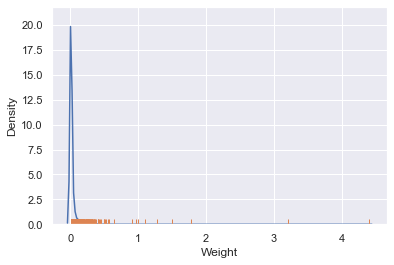

In [17]:
links = Pww_df.where((np.triu(np.ones(Pww_df.shape))).astype(np.bool_)) \
              .melt(ignore_index=False, var_name='Target', value_name='Weight') \
              .dropna() \
              .query("""Weight !=0""") \
              .reset_index() \
              .rename(columns={'index':'Source'})

sns.kdeplot(data=links, x='Weight')
sns.rugplot(data=links, x='Weight')
links.describe().T

In [18]:
np.unique(links.Source.tolist() + links.Target.tolist()).shape

(302,)

In [19]:
tol = -1
data_gephi = links#.query("Weight >= @tol").sort_values('Weight')

In [21]:
G = nx.from_pandas_edgelist(data_gephi, 'Source', 'Target', ['Weight'])
dw = pd.Series(dict(G.degree()))
# _=plot_degree_summary(G=G)

In [40]:
# pd.concat([dw,Mwd_df.sum(axis=1)])
(Mwd_df.sum(axis=1) == dw).any()
Mwd_df.sum(axis=1)

accessory             4
aesthetic             4
all                   4
allure                3
ambassador            4
                     ..
world                 5
x                     5
year                  4
zara                  6
zebraapua_official    3
Length: 302, dtype: int64

In [39]:
node = 'accessory'
data_gephi.query("(Source == @node) or (Target == @node)").shape

(39, 3)

In [ ]:
# data_gephi.to_csv(f'data/processed/col_{text_col}__tol_{tol}__links.csv',
#                   encoding='UTF-16',index=False)

# pd.concat([data_gephi.Source,
#            data_gephi.Target],
#           ignore_index=True) \
#   .drop_duplicates() \
#   .sort_values() \
#   .to_frame(name='Id') \
#   .eval("Label=Id") \
#   .merge(obj_rate_cat,how='left',on='Id',validate='m:1') \
#   .to_csv(f'data/processed/col_{text_col}__tol_{tol}__nodes.csv',encoding='UTF-16',index=False)